## PDF research paper analysis (idea #2)

### Psuedo code : 
```
Given a directory of PDF
Loop over each PDF X in the directory
    Extract page #1 and last page from X and create a 2-page version X-2.pdf
    Convert 2-page PDFs to text → X-2.txt

Make a network G with nodes which are the papers (text files)

// Double loop over all text files
Forall Text files P
    Forall Text files Q, where Q!=P
        W = Calculate similarity of P and Q (many options)
        Add edge (P,Q) with weight W       

// Now we have a complete mesh with weights

Sort edges from smallest weight to biggest weight
Loop over the edges E in this sorted order
     If deleting E from G will disconnect the graph -- break out of loop
     Otherwise, delete E

How do you know a graph is connected?
    If you do breadth first search in the graph (recursive BFS)
     Then in the BFS tree you will have as many nodes as in the graph

Output all surviving edges (did not get deleted) as 3 columns CSV
Node Id, Node ID, weight
```

Refernaces: 
https://stackoverflow.com/questions/12118720/python-tf-idf-cosine-to-find-document-similarity


In [4]:
## Data reading and initial data pre processing. 

from PyPDF2 import PdfFileReader, PdfFileWriter
import glob
from pathlib import Path

def creat_2p_PDFs():
    for pdf_path in glob.iglob('../static/*.pdf', recursive=True):
        pdf_name = pdf_path.split("\\")[1]
        pdf = PdfFileReader(str(pdf_path))
        pdf_numberOfPages = pdf.getNumPages()

        ## get first and last page
        pdf_writer = PdfFileWriter()
        pageFirst = pdf.getPage(0)
        pageLast  = pdf.getPage(pdf_numberOfPages-1)
        pdf_writer.addPage(pageFirst)
        pdf_writer.addPage(pageLast)

        with Path('/PUBS_2P/2P_'+pdf_name).open(mode="wb") as output_file:
            pdf_writer.write(output_file)

creat_2p_PDFs()

In [35]:
## 2 pages pdf reading and content into a data frame

import pandas as pd

def pdf2P_intoDataframe():
    pdf_cabinet = []
    for pdf_path in glob.iglob('../PUBS_2P/*.pdf', recursive=True):
        pdf2P_name = pdf_path.split("\\")[1]
        pdf2P = PdfFileReader(str(pdf_path))
        pdf2P_page1 = pdf2P.getPage(0)
        pdf2P_page2 = pdf2P.getPage(1)
        
        pdf2P_Page1Content = pdf2P_page1.extractText()
        pdf2P_Page2Content = pdf2P_page2.extractText()
        pdf2P_Content = pdf2P_Page1Content + pdf2P_Page2Content
        
        pdf_cabinet.append([pdf2P_name,pdf2P_Page1Content,pdf2P_Page2Content,pdf2P_Content])
        
        
    return pd.DataFrame(pdf_cabinet, columns = ['fileName', 'pdf2P_Page1Content','pdf2P_Page2Content','pdf2P_Content'])

dataframe_pdf2p = pdf2P_intoDataframe()


In [98]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
import numpy.linalg as LA
import string
import re

stopwords = stopwords.words('english')


def Cosine_textComparison(doc1,doc2):
    
    corpus = doc1+doc2 # both doc1 and doc2 content
    cv = CountVectorizer(stop_words = stopWords)
    X = cv.fit(corpus)
    
    vectorizer = CountVectorizer(stop_words = stopwords )
    transformer = TfidfTransformer()

    doc1_VectorizerArray = X.transform(doc1).toarray()
    doc2_VectorizerArray = X.transform(doc2).toarray()

    df = pd.DataFrame([doc1_VectorizerArray[0],doc2_VectorizerArray[0]],columns=cv.get_feature_names())
    #print(df)
    
    cx = lambda a, b : round(np.inner(a, b)/(LA.norm(a)*LA.norm(b)), 3)

    cosine = 0
    
    for doc1_vector in doc1_VectorizerArray:
        #print (doc1_vector)
        for doc2_vector in doc2_VectorizerArray:
            #print (doc2_vector)
            cosine = cx(doc1_vector, doc2_vector)
            #print ('cosine ',cosine)
            
    return cosine

def clean_text(txt):
    txt_noPuncatuations = "".join([c for c in txt if c not in string.punctuation])
    txt_noNewLines = txt_noPuncatuations.replace('\n',' ')
    return txt_noNewLines
    
    

docAnalysisResult = []
counterNote = 0

for i in range(0, len(dataframe_pdf2p.index), 1):
    for j in range(i+1, len(dataframe_pdf2p.index), 1):
        doc1_obj = dataframe_pdf2p.iloc[ i , : ]
        doc2_obj = dataframe_pdf2p.iloc[ j , : ]
        doc1 = clean_text(doc1_obj.pdf2P_Content)
        doc2 = clean_text(doc2_obj.pdf2P_Content)
        
        if doc1 and doc2:  # remove empty pdfs
            cosine = Cosine_textComparison([doc1],[doc2])
            docAnalysisResult.append([doc1_obj.fileName,doc2_obj.fileName,cosine])
            counterNote = counterNote+ 1
            #print(counterNote)
            
result = pd.DataFrame(docAnalysisResult,columns=['doc1','doc2','cosine'])  
result.to_csv('result.csv', index=False)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062


5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343


6783
6784
6785
6786
6787
6788
6789
6790
6791
6792
6793
6794
6795
6796
6797
6798
6799
6800
6801
6802
6803
6804
6805
6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982


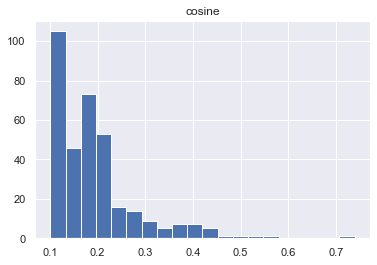

In [123]:
hist1 = result.loc[result['cosine'] >0.1].hist(bins=20)


In [115]:
import plotly.express as px

resultMatrix = result.pivot(index='doc1',columns='doc2',values='cosine')
fig = px.imshow(resultMatrix)
fig.update_layout(margin = dict(t=200,r=200,b=200,l=200),
    showlegend = False,
    width = 1000, height = 1000,
    autosize = False )
# fig.update_traces(coloraxis=[, selector=dict(type='heatmap'))

fig.show()

### June 14, 2021

Cos similarity heat map notes. Try writing a function MakeMap which takes as arguments:

    Df - 3 columns Doc1, Doc2, Cos
    LB float
    UB float (> LB)

It does:

    1. If cos similarity <= 0.0 [LB], color should be black
    2. If it is > 0.0 [LB] and < 0.1 [UB] (its color should be between blue and yellow according to color palette)
    3. If it is >= 0.1 [UB] it should be yellow

“Meaning” is 

    if cos < LB then basically the papers have nothing to do with each other
    If cos > UB then basically papers are in the “same area”
    In between means they have some connection

How to choose UB and LB?

Write a function Stats which takes as arguments:
    
    resultMatrix (pivot of Df) 
    LB
    UB
    returns:
        [ % of entries in matrix which are <= LB (i.e. % black)
          % of entries in matrix which are >= UB (i.e. % yellow)
          % of entries in matrix which are > LB and < UB (i.e. % in between blue and yellow) ]
          
#### Idea:

  We can use Stats() and MakeMap() to create an image which has
    
    - 20% black
    - 20% yellow
    - Rest in [blue-yellow] range

Try writing a function MakeNetwork which takes as arguments:

    Df - 3 columns Doc1, Doc2, Cos
    LB float
    UB float (> LB)
    
    It does:
        1. Does pivot to make square matrix which has all documents (rows) and all documents (columns) and cell I.J is cos similarity of doc I & doc J
        2. Loop over all cells (I,J) in matrix
            a. If cell <= 0.0 [LB], change cell to 0
            b. If cell > 0.0 [LB] and < 0.1 [UB] don’t do anything to cell
            c. If cell >= 0.1 [UB] change cell to 1
        3. Make a network (e.g. igraph, networkx)
            a. Make nodes (one per document)
            b. Loop over all entries in matrix.  If entry (I,J)=1 make an edge from node I to node J
            c. Draw network





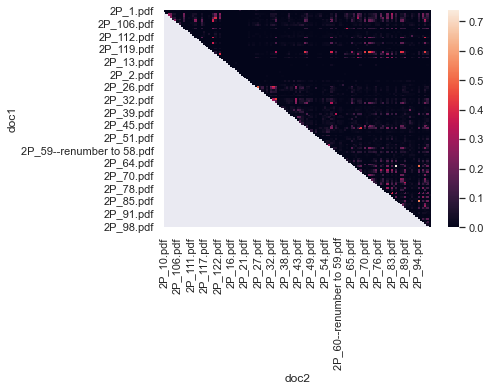

In [122]:
# import seaborn as sns; sns.set_theme()

# def MakeMap(result):
#     resultMatrix = result.pivot(index='doc1',columns='doc2',values='cosine')
#     ax = sns.heatmap(resultMatrix)

# MakeMap(result)



